In [1]:
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

df = pd.read_csv('/kaggle/input/netflix-movies-and-tv-shows/netflix_titles.csv')

df['duration_min'] = df[df['type'] == 'Movie']['duration'].str.extract('(\d+)').astype(float)
df['duration_seasons'] = df[df['type'] == 'TV Show']['duration'].str.extract('(\d+)').astype(float)

# Fill NaN values with 0 (since movies won't have seasons and TV shows won't have minutes)
df['duration_min'] = df['duration_min'].fillna(0)
df['duration_seasons'] = df['duration_seasons'].fillna(0)

# Drop the original duration column
df = df.drop(columns=['duration'])

data=df

label_encoders = {}
for column in ['type', 'rating', 'listed_in']:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

# Handle missing values
data = data.fillna(0)



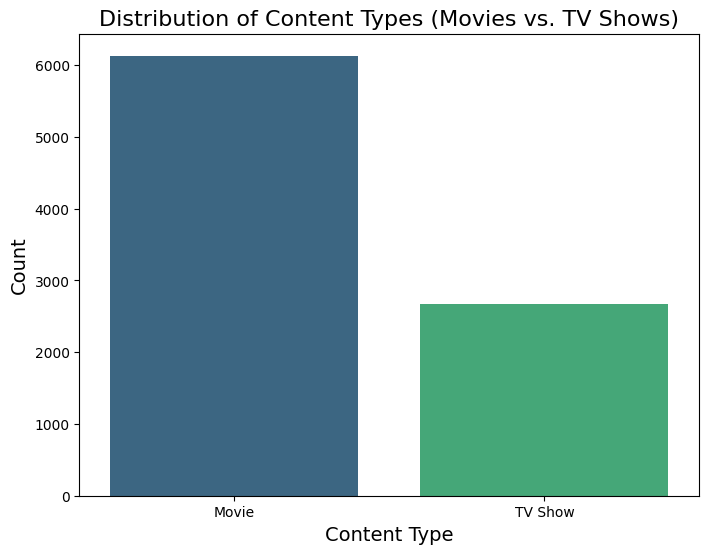

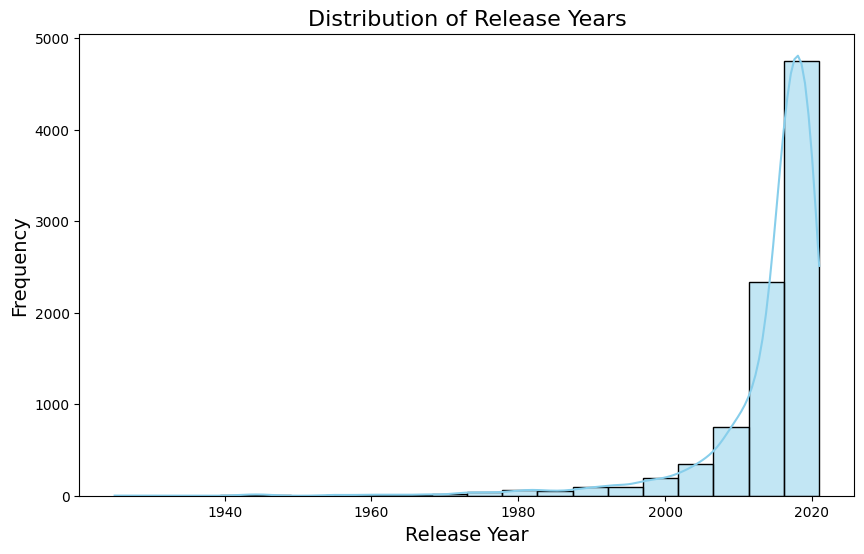

In [2]:
# Map type codes to labels
data['type_label'] = data['type'].map({0: 'Movie', 1: 'TV Show'})

# Plot the distribution of content types
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x='type_label', palette='viridis')
plt.title('Distribution of Content Types (Movies vs. TV Shows)', fontsize=16)
plt.xlabel('Content Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

# Plot the distribution of release years
plt.figure(figsize=(10, 6))
sns.histplot(data['release_year'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Release Years', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()

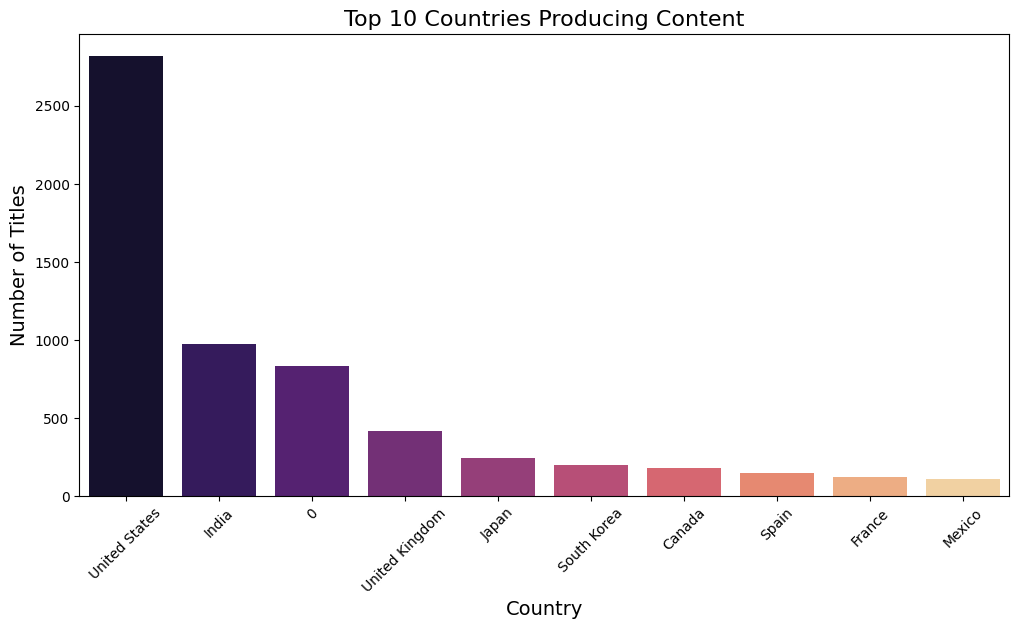

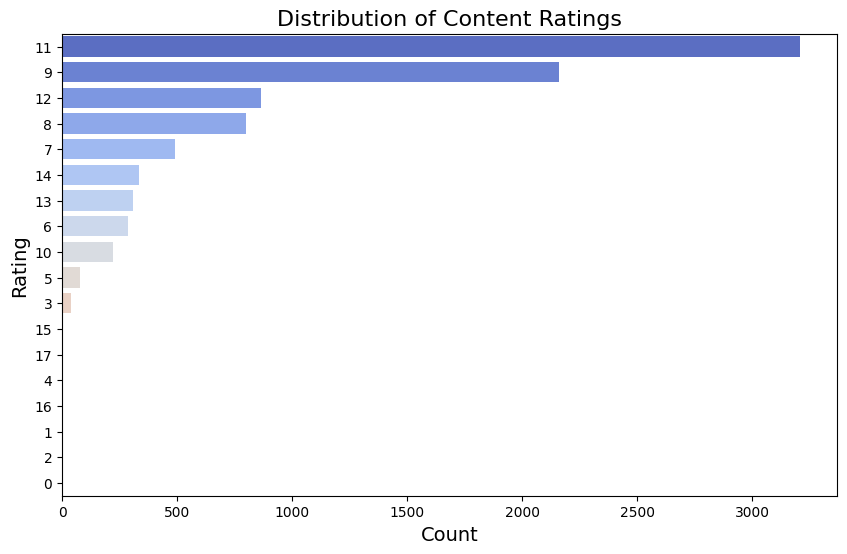

In [3]:
# Plot the top countries producing content
plt.figure(figsize=(12, 6))
top_countries = data['country'].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values, palette='magma')
plt.title('Top 10 Countries Producing Content', fontsize=16)
plt.xlabel('Country', fontsize=14)
plt.ylabel('Number of Titles', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# Plot the distribution of ratings
plt.figure(figsize=(10, 6))
sns.countplot(data=data, y='rating', palette='coolwarm', order=data['rating'].value_counts().index)
plt.title('Distribution of Content Ratings', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.show()

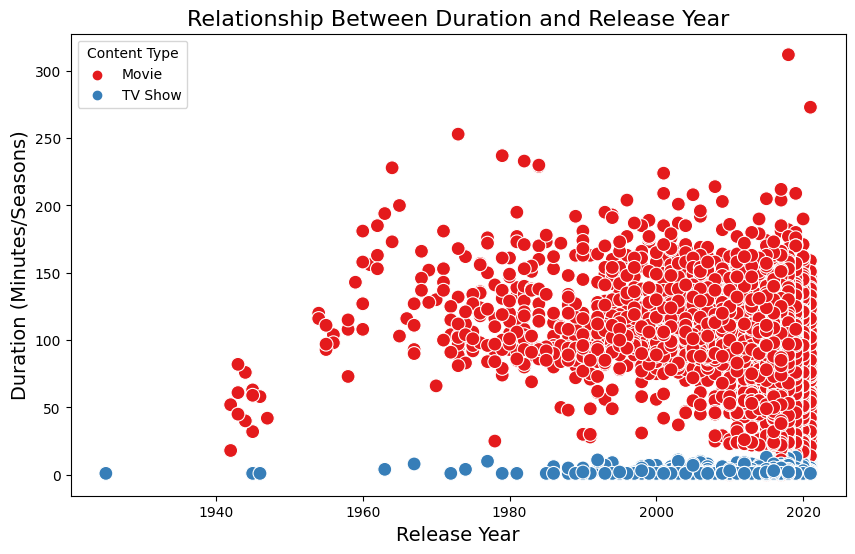

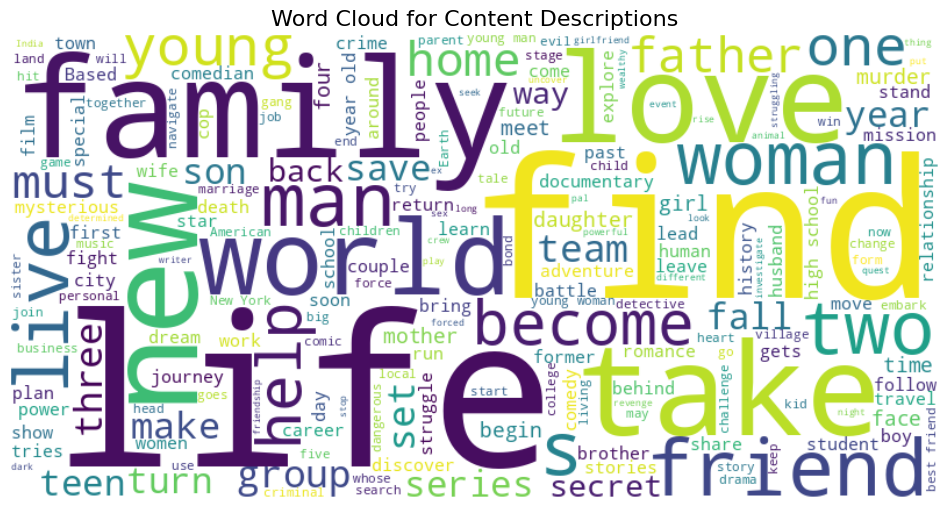

In [4]:
# Create a combined duration column
data['duration_combined'] = data.apply(lambda row: row['duration_min'] if row['type'] == 0 else row['duration_seasons'], axis=1)

# Plot the relationship between duration and release year
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='release_year', y='duration_combined', hue='type_label', palette='Set1', s=100)
plt.title('Relationship Between Duration and Release Year', fontsize=16)
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Duration (Minutes/Seasons)', fontsize=14)
plt.legend(title='Content Type')
plt.show()

from wordcloud import WordCloud

# Combine all descriptions into a single string
text = ' '.join(data['description'].dropna())

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Content Descriptions', fontsize=16)
plt.show()

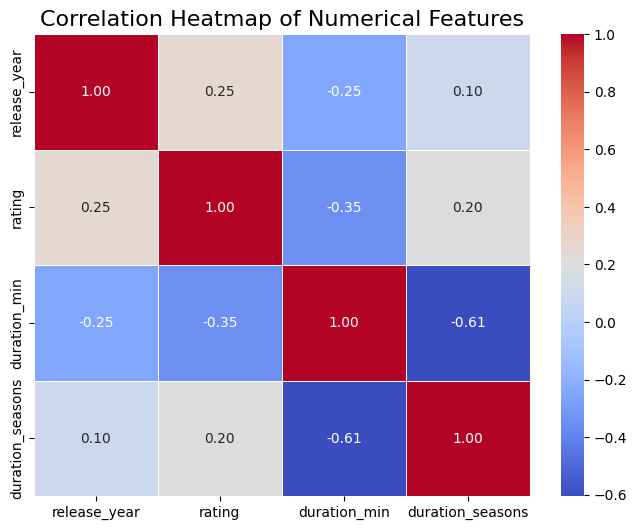

In [5]:
# Select numerical features
numerical_data = data[['release_year', 'rating', 'duration_min', 'duration_seasons']]

# Compute the correlation matrix
corr = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features', fontsize=16)
plt.show()

In [6]:
# Select features and target
X = data[['type', 'release_year', 'rating', 'duration_min', 'duration_seasons']]
y = data['listed_in']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

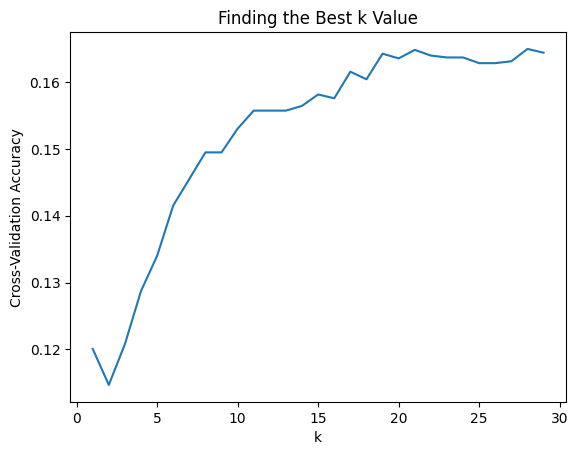

Best k value: 28


In [7]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Find the best k value
k_values = list(range(1, 30))
cv_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())

# Plot the results
plt.plot(k_values, cv_scores)
plt.xlabel('k')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Finding the Best k Value')
plt.show()

# Best k value
best_k = k_values[np.argmax(cv_scores)]
print(f'Best k value: {best_k}')

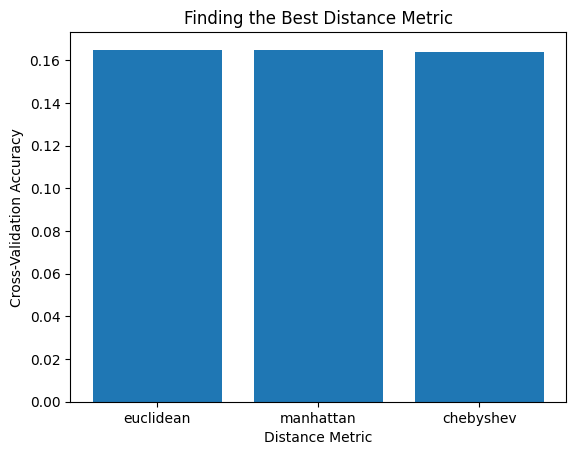

Best distance metric: manhattan


In [8]:
distance_metrics = ['euclidean', 'manhattan', 'chebyshev']
cv_scores_metrics = []

for metric in distance_metrics:
    knn = KNeighborsClassifier(n_neighbors=best_k, metric=metric)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores_metrics.append(scores.mean())

# Plot the results
plt.bar(distance_metrics, cv_scores_metrics)
plt.xlabel('Distance Metric')
plt.ylabel('Cross-Validation Accuracy')
plt.title('Finding the Best Distance Metric')
plt.show()

# Best distance metric
best_metric = distance_metrics[np.argmax(cv_scores_metrics)]
print(f'Best distance metric: {best_metric}')

<Figure size 1200x800 with 0 Axes>

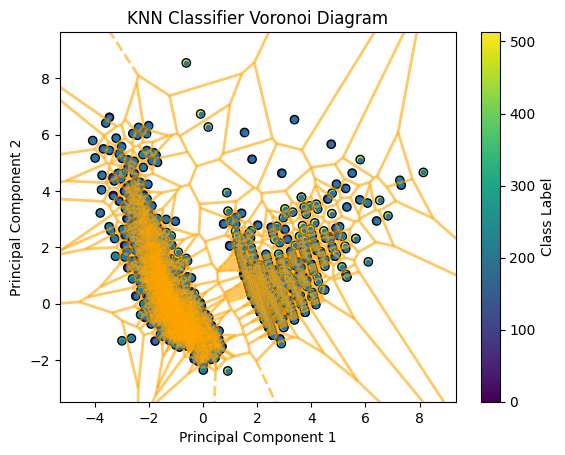

In [9]:
from sklearn.decomposition import PCA
from scipy.spatial import Voronoi, voronoi_plot_2d

# Train the final KNN model with the best k and distance metric
knn = KNeighborsClassifier(n_neighbors=best_k, metric=best_metric)
knn.fit(X_train, y_train)

# Create a meshgrid for visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Combine train and test data for visualization
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
X_combined_pca = pca.transform(X_combined)

# Generate Voronoi diagram
vor = Voronoi(X_combined_pca)

# Plot the Voronoi diagram
plt.figure(figsize=(12, 8))
voronoi_plot_2d(vor, show_vertices=False, line_colors='orange', line_width=2, line_alpha=0.6)
plt.scatter(X_combined_pca[:, 0], X_combined_pca[:, 1], c=y_combined, cmap='viridis', edgecolor='k')
plt.title('KNN Classifier Voronoi Diagram')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Class Label')
plt.show()